In [1]:
import tensorflow as tf
import pandas as pd
import os
import tensorflow_addons as tfa
import cv2
import glob

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow.python.ops.numpy_ops import np_config
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
from keras_unet_collection import models


from src.data_prepare import *
from src.utils import *
from src.modeling.models import *
from src.modeling.model_utils import *


/tmp/ipykernel_68716/3496455846.py:16: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
#K.set_image_dim_ordering('th')
np_config.enable_numpy_behavior()

# Data errors

In [3]:
annot_df = {'img_name' : [],'classes' : [],'x' : [],'y' : [],'width' : [],'height' : []}
sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/train/labels/'))):
    ## Empty Labels
    try:
        tmp_df = pd.read_csv(f'kaggle/train/labels/{i}',header=None)
        for j in tmp_df[0].values:
            annot_df['img_name'].append(f'kaggle/train/images/{i.split(".")[0]}.png')
            #sample['image'] = Image.open(f'kaggle/train/images/{i.split(".")[0]}.png').convert('RGB')
            annot_df['classes'].append(j.split()[0])
            annot_df['x'].append(j.split()[1])
            annot_df['y'].append(j.split()[2])
            annot_df['width'].append(j.split()[3])
            annot_df['height'].append(j.split()[4])
            ###
            sample['label'].append(j.split()[0])
            sample['bbox'].append(j.split()[1])
            sample['bbox'].append(j.split()[2])
            sample['bbox'].append(j.split()[3])
            sample['bbox'].append(j.split()[4])
    except pd.errors.EmptyDataError:
        empty_list.append(i)
        continue

2474it [00:01, 1511.16it/s]


In [4]:
empty_list

['07081.txt',
 '02528.txt',
 '04966.txt',
 '06229.txt',
 '04285.txt',
 '03798.txt',
 '02448.txt']

In [5]:
df = pd.DataFrame.from_dict(annot_df)


## Plot Images

In [6]:
def plot_image(value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * image.size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * image.size[1]
        width = float(rows['width']) * image.size[0]
        height = float(rows['height']) * image.size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

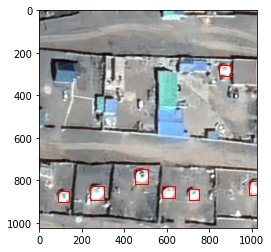

In [7]:
plot_image(0)

In [8]:
def plot_resized_image(resize_size:tuple,value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Resize image
    image = tf.image.resize_with_pad(image,resize_size[0],resize_size[1])
    image = image.astype(np.uint8)

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * resize_size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * resize_size[1]
        width = float(rows['width']) * resize_size[0]
        height = float(rows['height']) * resize_size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

2022-06-02 05:41:12.849311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 05:41:12.850145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 05:41:12.854344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 05:41:12.855147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 05:41:12.855916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

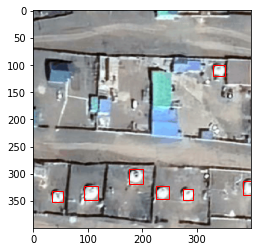

In [9]:
plot_resized_image((400,400),0)

In [10]:
df

img_name classes         x         y     width  \
0      kaggle/train/images/04320.png       0  0.981836  0.815967  0.036328   
1      kaggle/train/images/04320.png       0  0.593945  0.836572  0.059375   
2      kaggle/train/images/04320.png       0  0.470215  0.762305  0.062695   
3      kaggle/train/images/04320.png       0  0.264795  0.839844  0.064355   
4      kaggle/train/images/04320.png       0  0.111328  0.854736  0.051172   
...                              ...     ...       ...       ...       ...   
23450  kaggle/train/images/01431.png       0  0.901563  0.052295  0.129297   
23451  kaggle/train/images/01431.png       0  0.543652  0.027588  0.131445   
23452  kaggle/train/images/00666.png       0  0.848437  0.108545  0.137109   
23453  kaggle/train/images/05487.png       0  0.958496  0.692871  0.083008   
23454  kaggle/train/images/05487.png       0  0.691895  0.947754  0.112305   

         height  
0      0.067676  
1      0.056152  
2      0.069336  
3      0.066016  
4      0.052832  
...         ...  
23450  0.104590  
23451  0.055176  
23452  0.137012  
23453  0.102539  
23454  0.096680  

[23455 rows x 6 columns]

In [11]:
def convert_bbox(x):
    img = Image.open(x['img_name'])
    #sizes = img.size
    # Load xy, width and height
    x_mod = (float(x['x']) - float(x['width']) * 0.5) * img.size[0]
    y_mod = (float(x['y']) - float(x['height']) * 0.5) * img.size[1]
    width_mod = float(x['width']) * img.size[0]
    height_mod = float(x['height']) * img.size[1]
    return pd.Series([x_mod,y_mod,width_mod,height_mod],index=['x_mod','y_mod','width_mod','height_mod'])

In [12]:
df[['x_mod','y_mod','width_mod','height_mod']] = df.apply(lambda x: convert_bbox(x),axis=1)
df[['x_mod','y_mod','width_mod','height_mod']] = df[['x_mod','y_mod','width_mod','height_mod']].astype(int)

In [13]:
df['xmin'] = df['x_mod']
df['xmax'] = df['xmin'] + df['width_mod']
df['ymin'] = df['y_mod']
df['ymax'] = df['ymin'] + df['height_mod']

(-0.5, 1075.225, 1075.225, -0.5)

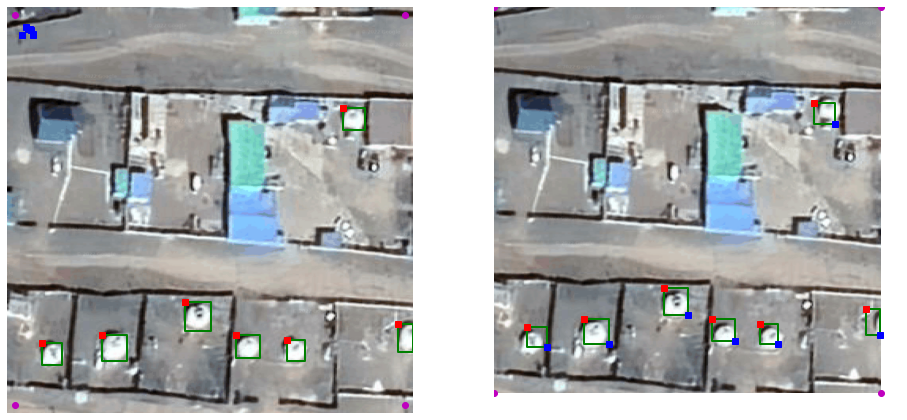

In [14]:

#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 20
tr_y1 = 20
tr_x2 = 20
tr_y2 = 20



p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['x_mod'],bb_boxes.iloc[i]['y_mod'],
                bb_boxes.iloc[i]['width_mod'],bb_boxes.iloc[i]['height_mod']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['x_mod'] = (bb_boxes['x_mod'] - p1[1])/(p2[1]-p1[1])*img.shape[0]
bb_boxes1['y_mod'] = (bb_boxes['y_mod'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['width_mod'] = (bb_boxes['width_mod'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['height_mod'] = (bb_boxes['height_mod'] - p1[0])/(p3[0]-p1[0])*img.shape[1]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

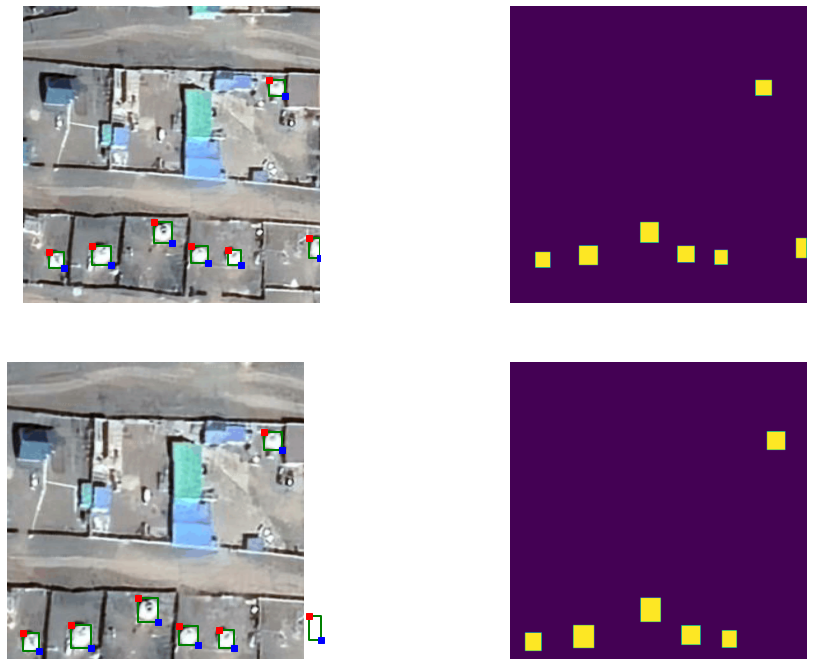

In [15]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

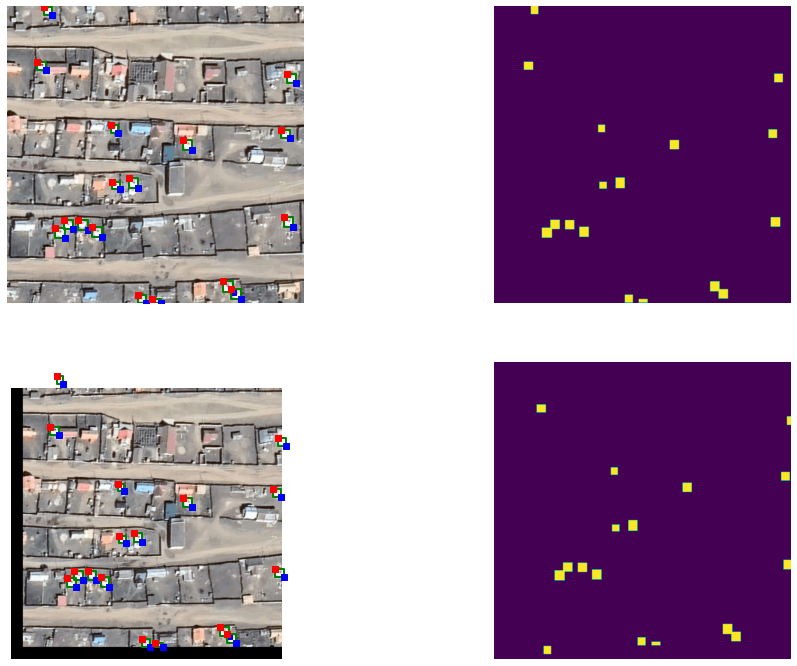

In [16]:
### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

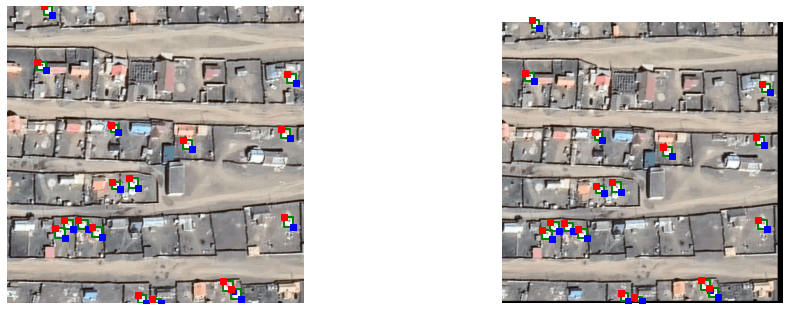

In [17]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)

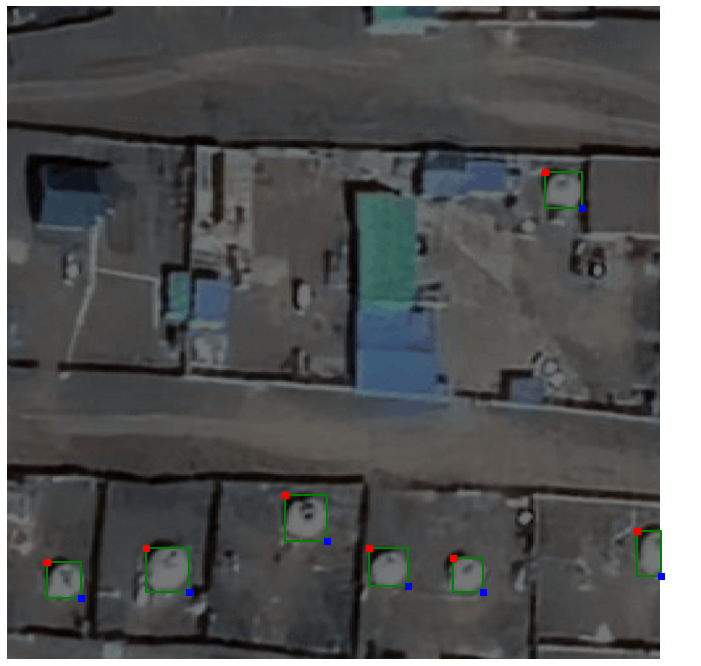

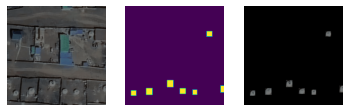

In [18]:
#### Put all the augmentations in 1 function with a flag for augmentation


name_str,img,bb_boxes = get_image_name(df,1,augmentation=True)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(16,12))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

## Prepare data

In [19]:
##### Testing the generator

training_gen = generate_train_batch(df,10,augmentation=True,img_size=(1024,1024))

In [20]:
batch_img,batch_mask = next(training_gen)

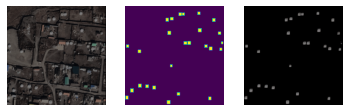

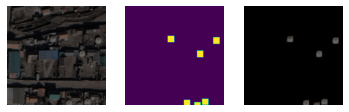

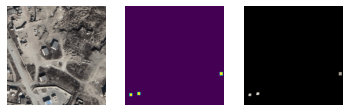

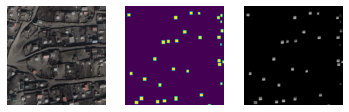

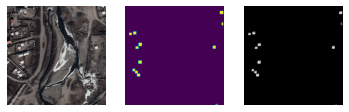

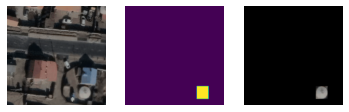

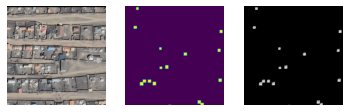

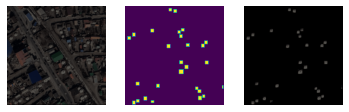

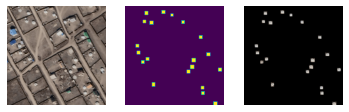

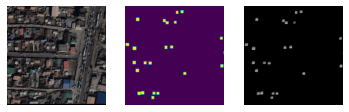

In [21]:
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask))
    plt.axis('off')
    plt.show()

In [22]:
K.set_image_data_format('channels_last')

### Define Model

In [23]:
model_unet = UNet((1024,1024,3))
#model_effunet = UEfficientNet('b4',(1024,1024,3),0.2)
model_swinunet = models.swin_unet_2d((1024, 1024, 3), filter_num_begin=64, n_labels=1, depth=4, stack_num_down=2, stack_num_up=2, 
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
                            output_activation='Sigmoid', shift_window=True, name='swin_unet')

In [24]:
batch_size = 8

In [25]:
### Generator 
training_gen = generate_train_batch(df,batch_size,augmentation=True,img_size=(1024,1024))
smooth = 1.
model_unet.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
              loss=bce_dice_loss, metrics=[my_iou_metric])
model_swinunet.compile(loss=bce_dice_loss,
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=[my_iou_metric]
              )

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1024, 1024,   2320        ['conv2d[0][0]']                 
                                16)                                                           

In [27]:
model_swinunet.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 patch_extract (patch_extract)  (None, 262144, 12)   0           ['input_2[0][0]']                
                                                                                                  
 patch_embedding (patch_embeddi  (None, 262144, 64)  16778048    ['patch_extract[0][0]']          
 ng)                                                                                              
                                                                                    

In [28]:
steps_per_epoch = int(len(df) / batch_size)

In [30]:
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=int(3),
    min_delta=0.01,
    mode='min',
    restore_best_weights=True
)

In [31]:
history = model_unet.fit(training_gen,
                         steps_per_epoch=steps_per_epoch,
                         epochs=3)

Epoch 1/10
2931/2931 [==============================] - 1034s 353ms/step - loss: 0.1334 - my_iou_metric: 0.6600
Epoch 2/10
2931/2931 [==============================] - 1033s 352ms/step - loss: 0.1233 - my_iou_metric: 0.6845
Epoch 3/10
2931/2931 [==============================] - 1028s 351ms/step - loss: 0.1159 - my_iou_metric: 0.6993
Epoch 4/10
2931/2931 [==============================] - 1033s 352ms/step - loss: 0.1129 - my_iou_metric: 0.7084
Epoch 5/10
2931/2931 [==============================] - 1026s 350ms/step - loss: 0.1088 - my_iou_metric: 0.7184
Epoch 6/10
2931/2931 [==============================] - 1029s 351ms/step - loss: 0.1050 - my_iou_metric: 0.7275
Epoch 7/10
2931/2931 [==============================] - 1036s 353ms/step - loss: 0.1009 - my_iou_metric: 0.7375
Epoch 8/10
2931/2931 [==============================] - 1028s 351ms/step - loss: 0.0963 - my_iou_metric: 0.7484
Epoch 9/10
2931/2931 [==============================] - 1028s 351ms/step - loss: 0.0909 - my_iou_metric:

In [32]:
model_unet.save('object_unet_0602.h5')

In [30]:
model = keras.models.load_model('object_unet.h5',
                               compile=False
                               )

In [31]:
model.compile(loss=bce_dice_loss,
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=[IOU_calc]
              )

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
annot_df = {'img_name' : []}
#sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/test/images/'))):
    ## Empty Labels
    annot_df['img_name'].append(f'kaggle/test/images/{i.split(".")[0]}.png')


3712it [00:00, 1458341.74it/s]


In [34]:
test_df = pd.DataFrame.from_dict(annot_df)

In [50]:
test_gen = generate_test_batch(test_df,8,img_size=(1024,1024))

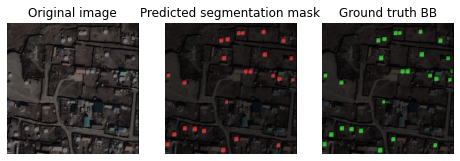

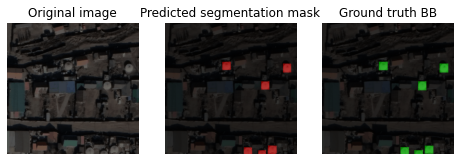

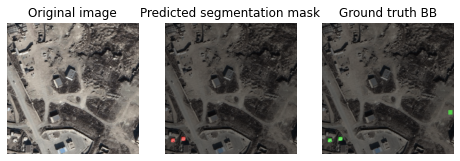

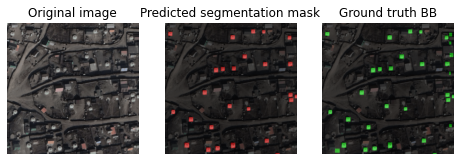

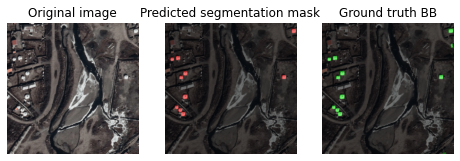

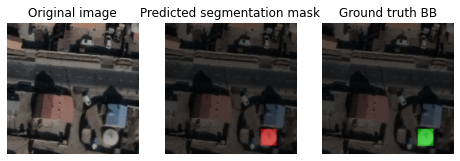

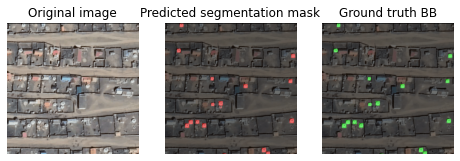

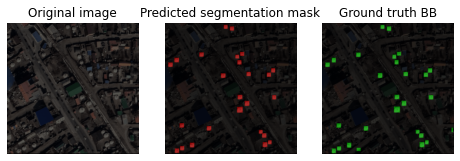

In [51]:
pred_all= model_unet.predict(batch_img)
np.shape(pred_all)

for i in range(8):
    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()

0

In [65]:
for car_number in range(1,label(0)[1]+1):
    print(car_number)

In [68]:
#### Function for drawing bounding boxes, taken from Ryan's code on Udacity

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for ger_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == ger_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>30) & (np.max(nonzerox)-np.min(nonzerox)>30)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img

def test_new_img(img):
    img = cv2.resize(img,(1024, 1024))
    img = np.reshape(img,(1,1024, 1024,3))
    pred = model_unet.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = im_pred[:,:,0]
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

(-0.5, 1023.5, 1023.5, -0.5)

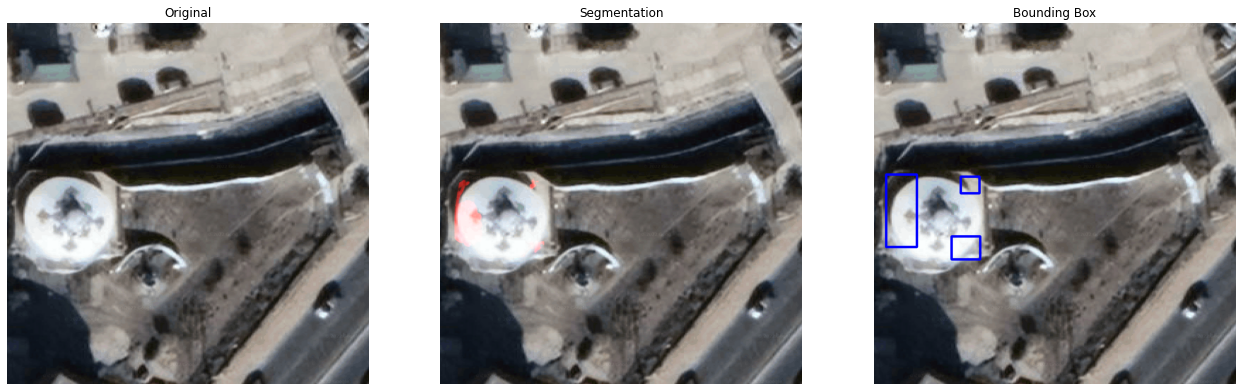

In [70]:

test_img = 'kaggle/test/images/00017.png'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = test_new_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]



img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)



#heatmap = im_pred[:,:,0]

#labels = label(heatmap)
# Draw bounding boxes on a copy of the image
#draw_img = draw_labeled_bboxes(np.copy(im), labels)
# Display the image
#img_pred = im
#im_pred[:,:,]

draw_img = get_BB_new_img(im)

plt.figure(figsize=(22,20))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentation')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off')

